In [2]:
import pm4py
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.generic.log import case_statistics
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# Load CSV event log

df = pd.read_csv("../../data/Playground/KLINKDATEN_2022_converted_documentation.csv")
df = df[df["time:timestamp"].notna()]
df.sort_values(["sid", "time:timestamp"])
df['sid'] = df['sid'].astype(str)
df['rid'] = df['rid'].astype(str)
# Convert DataFrame to event log (ensuring proper column names)
backlog_df = df
event_log = pm4py.format_dataframe(
    df, 
    case_id="rid",  # Column representing case IDs
    activity_key="concept:name",  # Column representing activity names
    timestamp_key="time:timestamp"  # Column representing timestamps
)


/tmp/ipykernel_782554/383234596.py:3: DtypeWarning: Columns (14,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../data/Playground/KLINKDATEN_2022_converted_documentation.csv")


In [ ]:
# Get all variants and their frequency
variants_count = case_statistics.get_variant_statistics(event_log)

# Sort variants by occurrence
variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)

# Print the top 5 variants
for variant in variants_count[:8]:
    print(f"Variant: {variant['variant']}, Count: {variant['count']}")

# Get the top N variants
top_n_variants = {v["variant"] for v in variants_count[:8]}  # Adjust '5' to your preferred N

# Apply filtering
filtered_log = variants_filter.apply(event_log, top_n_variants)

Variant: ('report_date',), Count: 235050
Variant: ('report_date', 'countercheck_date'), Count: 81565
Variant: ('report_date', 'read_date'), Count: 49307
Variant: ('report_date', 'read_date', 'approval_date'), Count: 44145
Variant: ('report_date', 'read_date', 'countercheck_date'), Count: 37122
Variant: ('report_date', 'approval_date'), Count: 26610
Variant: ('report_date', 'read_date', 'countercheck_date', 'approval_date'), Count: 16129
Variant: ('report_date', 'countercheck_date', 'approval_date'), Count: 12351


In [ ]:
df = pm4py.convert_to_dataframe(filtered_log)


rid
10180685    1
12378445    1
12487564    1
13149296    1
13149301    1
           ..
14513143    1
14513145    1
14513157    1
14513162    1
14513163    1
Name: rid, Length: 502279, dtype: int64

In [ ]:
rid_count_top_8 = df["rid"].nunique()
rid_count_all = backlog_df["rid"].nunique()
print(f"The top 8 variant have {rid_count_top_8} reports, all variants have {rid_count_all}. The ratio is {rid_count_top_8/rid_count_all:.2%}")
print("We only consider the top 8 Variants from now on")

The top 8 variant have 502279 reports, all variants have 593387. The ratio is 84.65%
We only consider the top 8 Variants from now on


Analyse the number of Reports (RIDs) per Day

In [ ]:
# Analyse the number of RIDs per Day
report_df = df[["rid", "time:timestamp"]]
report_df = report_df.groupby("rid").max()
report_df["time:timestamp"] = report_df["time:timestamp"].dt.date
rids_per_day = report_df["time:timestamp"].value_counts().sort_index()
rids_per_day_df = rids_per_day.reset_index()
rids_per_day_df.columns = ["date", "rid_count"]
#rids_per_day_df.sort_values("rid_count")

On 766 days, a median of 871.0 was processed


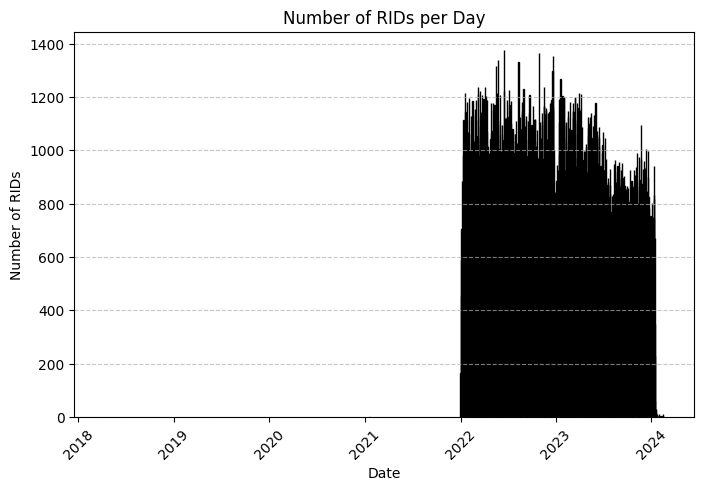

In [ ]:
per_day = rids_per_day_df["rid_count"].median()
print(f"On {len(rids_per_day_df)} days, a median of {per_day} was processed")

# Plot the data
plt.figure(figsize=(8, 5))
plt.bar(rids_per_day_df["date"], rids_per_day_df["rid_count"], color='skyblue', edgecolor='black')

# Formatting
plt.xlabel("Date")
plt.ylabel("Number of RIDs")
plt.title("Number of RIDs per Day")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

### Analyse Reports per Department

In [ ]:
area_df = df[["rid", "area"]]
area_df = area_df.groupby("area")["area"].value_counts().reset_index()
area_df.columns = ["area", "rid_count"]

On 49 areas, a median of 6225.0 reports was processed


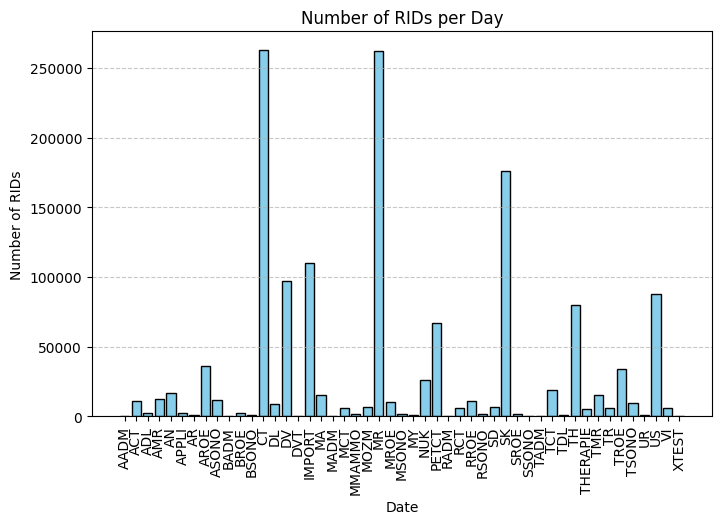

In [ ]:
area_med = area_df["rid_count"].median()
print(f"On {len(area_df)} areas, a median of {area_med} reports was processed")

# Plot the data
plt.figure(figsize=(8, 5))
plt.bar(area_df["area"], area_df["rid_count"], color='skyblue', edgecolor='black')

# Formatting
plt.xlabel("Date")
plt.ylabel("Number of RIDs")
plt.title("Number of RIDs per Day")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

### Analyse Resources per Department

In [ ]:
res_dep_df = df[["rid", "area", "org:resource"]]
resources_per_dep = res_dep_df.groupby("area")["org:resource"].nunique().reset_index()
resources_per_dep

,area,org:resource
0,AADM,12
1,ACT,83
2,ADL,30
3,AMR,58
4,AN,70
5,APPLI,25
6,AR,41
7,AROE,47
8,ASONO,40
9,BADM,1


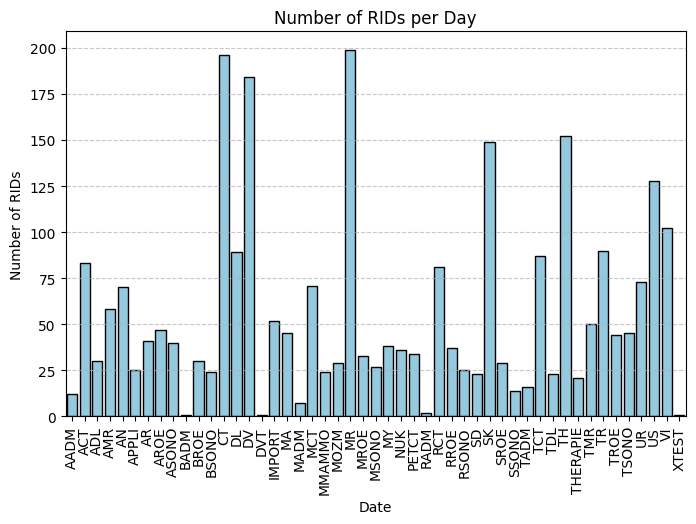

In [ ]:
import seaborn as sns 
# Plot the data
plt.figure(figsize=(8, 5))
sns.barplot(x="area", y="org:resource", data=resources_per_dep, color='skyblue', edgecolor='black')

# Formatting
plt.xlabel("Date")
plt.ylabel("Number of RIDs")
plt.title("Number of RIDs per Day")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [ ]:
res_dep_group_df = res_dep_df.groupby(["org:resource", "area"]).count().reset_index()
res_dep_group_df.columns = ["org:resource", "area", "rid_count"]
dep_per_resource_df = res_dep_group_df.groupby("org:resource")["area"].nunique().reset_index().sort_values("area", ascending=False)

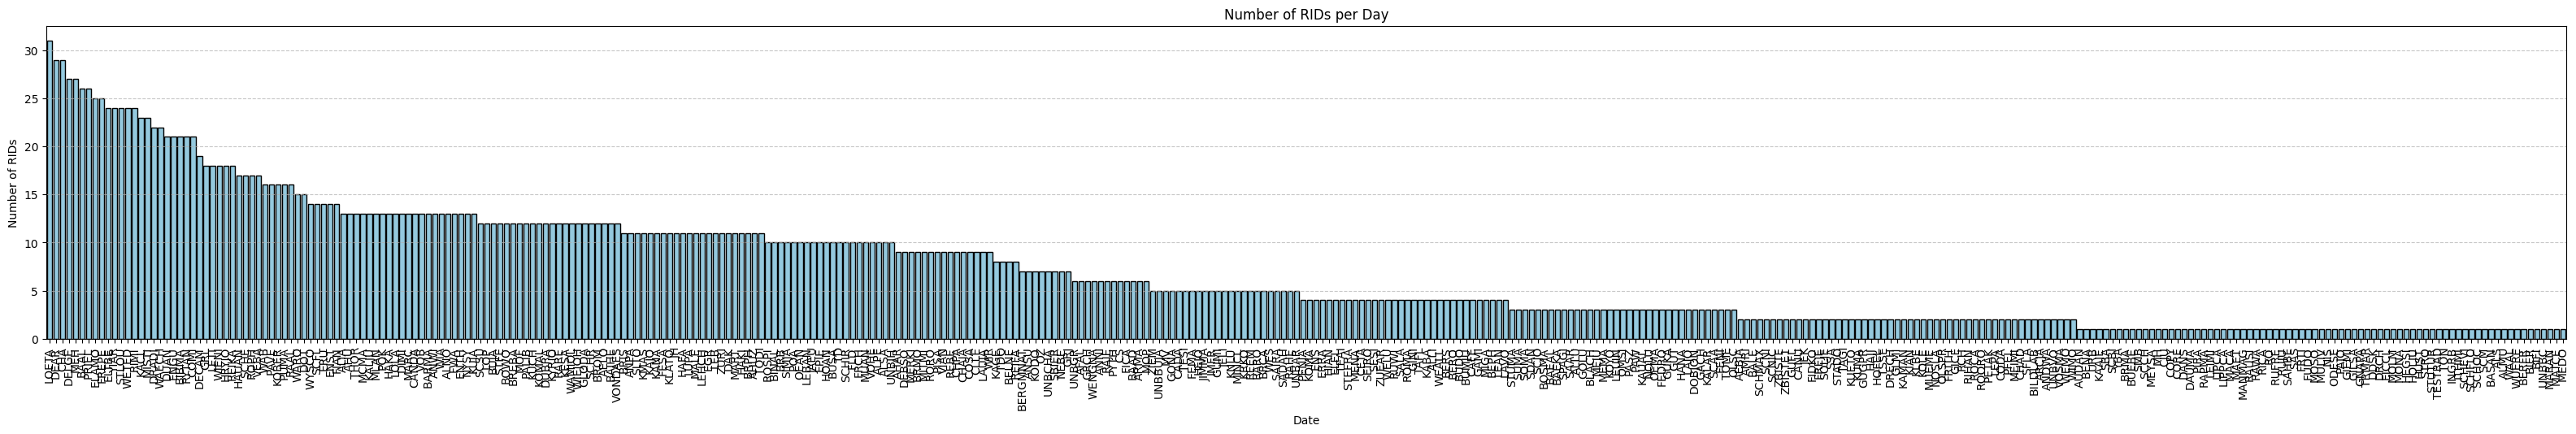

In [ ]:
plt.figure(figsize=(40, 5))
sns.barplot(x="org:resource", y="area", data=dep_per_resource_df, color='skyblue', edgecolor='black')

# Formatting
plt.xlabel("Date")
plt.ylabel("Number of RIDs")
plt.title("Number of RIDs per Day")
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

Analysis with variants